# 线性SVM分类 Linear SVM Classification

## 硬间隔最大化 Hard Margin Maximization

以鸢尾植物数据集来说明SVM

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# 1. 加载数据集
from sklearn import datasets
iris = datasets.load_iris()
X = iris['data'][:,(2, 3)]  # 花瓣的长度和宽度
y = iris['target']

In [3]:
# 2. 仅对变色鸢尾和山鸢尾进行分类
target = (y == 0) | (y == 1)  # 维吉尼亚鸢尾不返回
X = X[target]
y = y[target]

- 利用`Scikit-Learn`的`SVR()`函数实现支持向量回归

In [4]:
from sklearn.svm import SVC # Linear Support Vector Classification

In [5]:
# 3. 使用SVM()进行预测
svm_clf = SVC(kernel='linear', C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

>公式1: 超平面方程
$$
w^Tx+b=0
$$

以二维平面为例子，超平面方程为$w_0x_0+w_1x_1+b=0$，由此可以得到$x_1 = -\frac{w_0}{w_1} x_0 - \frac{b}{w_1}$

<img src="./images/other/5-1.png" width="400">

In [6]:
# 4. 绘制决策边界
def plot_decision_boundary(model, Xmin, Xmax):
    w = model.coef_[0]        # 特征权重
    b = model.intercept_[0]   # 截距项
    
    x0 = np.linspace(Xmin, Xmax, 200)
    boundary = -(w[0]/w[1])*x0 - (b/w[1])
    
    margin = 1 / w[1]
    up_margin = boundary + margin
    down_margin = boundary - margin
    
    svs = model.support_vectors_  # 求出过切线的点 (1.9,0.4),(3,1.1)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')  # 标注支持向量
    
    plt.plot(x0, up_margin, 'k--', linewidth=2)
    plt.plot(x0, boundary, 'k-', linewidth=2)
    plt.plot(x0, down_margin, 'k--', linewidth=2)

In [7]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='./Fonts/SourceHanSerifSC-Medium.otf', size=12)

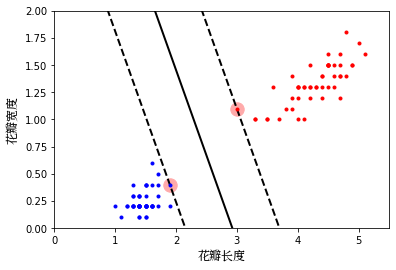

In [8]:
# 5. 绘制大分类间隔
plot_decision_boundary(svm_clf, 0, 5.5)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "r.")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "b.")

plt.xlabel("花瓣长度", fontproperties=my_font)
plt.ylabel("花瓣宽度", fontproperties=my_font)
plt.axis([0, 5.5, 0, 2])

plt.show()

<img src="./images/other/5-2.png" width="600">

基本模型是定义在特征空间上的间隔最大的线性分类器`间隔最大化`使它有别于感知机

## 特征缩放敏感性 Sensitivity to feature scales

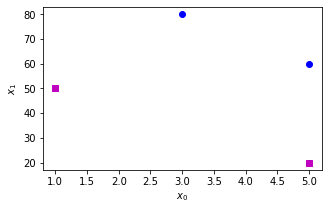

In [9]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]])
ys = np.array([0, 0, 1, 1])

def plot_sensitivity(X,y,title=""):
    plt.figure(figsize=(5,3))
    #plt.axis([0, 6, 0, 90])
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ms")
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.title(title,)
    
plot_sensitivity(X=Xs,y=ys)
plt.show()

- 不进行特征缩放

In [10]:
svm_clf = SVC(C=100, kernel="linear")
svm_clf.fit(Xs,ys)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

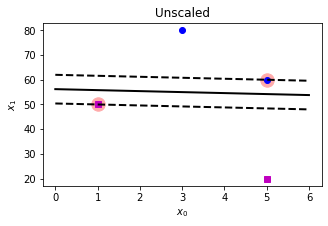

In [11]:
plot_sensitivity(X=Xs,y=ys,title="Unscaled")
plot_decision_boundary(svm_clf, 0, 6)

- 进行特征缩放

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xs_scaled = scaler.fit_transform(Xs)

svm_clf_scaled = SVC(C=100, kernel="linear")
svm_clf_scaled.fit(Xs_scaled, ys)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

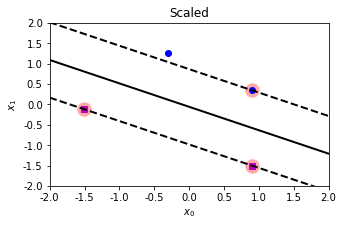

In [13]:
plot_sensitivity(X=Xs_scaled, y=ys, title="Scaled")
plt.axis([-2, 2, -2, 2])
plot_decision_boundary(svm_clf_scaled, -2, 2)

SVM对于特征缩放十分敏感, 未经过特征缩放虚线接近于水平。进行特征缩放之后决策边界看起来好了很多。

## 软间隔分类

- 训练数据中有一些`特异点(outlier)`,不能满足函数间隔大于等于1的约束条件。
- 引入`软间隔`的概念,允许支持向量机在一些样本上不满足约束。

<img src="./images/other/5-3.png" width="600">

- 利用`Scikit-Learn`的创建SVM模型，使用超参数`C`指定正则化参数
- 如果SVM模型过拟合，可以尝试通过降低`C`来对其进行正则化

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [15]:
# 1. 加载数据集
iris = datasets.load_iris()
X = iris['data'][:,(2, 3)]    # 花瓣的长度和宽度
y = (iris['target'] == 2).astype(np.float64)  # 维吉尼亚鸢尾

In [16]:
# 2. 流水线:先特征缩放，再拟合线性SVM模型
svm_clf_scaled = Pipeline([
            ("scaler", StandardScaler()),
            ("linear_svm", LinearSVC(C=1, loss="hinge", random_state=42))
        ])

In [17]:
# 3. 拟合预测
svm_clf.fit(X,y)
svm_clf.predict([[5.5, 1.7]])

array([1.])

- 尝试适用不同的超参数`C`

In [18]:
scaler = StandardScaler()
svm_clf_1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf_2 = LinearSVC(C=100, loss="hinge", random_state=42)

# C=1
svm_clf_scaled_1 = Pipeline([
            ("scaler", scaler),
            ("linear_svm",svm_clf_1)
        ])

# C=100
svm_clf_scaled_2 = Pipeline([
            ("scaler", scaler),
            ("linear_svm", svm_clf_2)
        ])

svm_clf_scaled_1.fit(X,y)
svm_clf_scaled_2.fit(X,y)

/Users/jin/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svm',
                 LinearSVC(C=100, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

- 绘制决策边界

In [19]:
# 转化为未经过特征缩放的参数
def convert_param(model, scaler=scaler):
    w = model.coef_[0] / scaler.scale_
    b = model.decision_function([-scaler.mean_ / scaler.scale_])
    
    model.coef_ = np.array([w])
    model.intercept_ = np.array([b])
    
    t = y * 2 - 1
    support_vectors_index = (t*(X@w+b)<=1).ravel()
    model.support_vectors_ = X[support_vectors_index]

In [20]:
convert_param(svm_clf_1)
convert_param(svm_clf_2)
svm_clf_1.coef_,svm_clf_1.intercept_

(array([[0.928379 , 3.1434167]]), array([[-9.76416467]]))

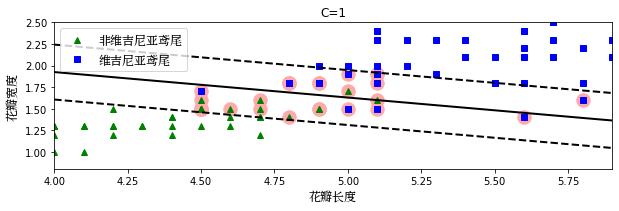

In [21]:
# C=1
plt.figure(figsize=(10,2.7))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^", label="非维吉尼亚鸢尾")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="维吉尼亚鸢尾")
plot_decision_boundary(svm_clf_1, 4, 5.9)

plt.xlabel("花瓣长度", fontproperties=my_font)
plt.ylabel("花瓣宽度", fontproperties=my_font)
plt.title('C=1')
plt.legend(loc="upper left", prop=my_font)
plt.axis([4, 5.9, 0.8, 2.5])

plt.show()

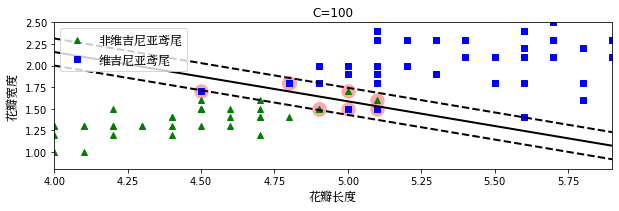

In [22]:
# C=100
plt.figure(figsize=(10,2.7))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^", label="非维吉尼亚鸢尾")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="维吉尼亚鸢尾")
plot_decision_boundary(svm_clf_2, 4, 5.9)

plt.axis([4, 5.9, 0.8, 2.5])
plt.xlabel("花瓣长度", fontproperties=my_font)
plt.ylabel("花瓣宽度", fontproperties=my_font)
plt.title("C=100")
plt.legend(loc="upper left", prop=my_font)

plt.show()

# 非线性SVM分类 Non-linear classification

处理非线性数据及的方法之一是添加更多的特征，比如多项式特征。某种情况下，这可能导致数据集变得线性可分离。

<img src="./images/other/5-4.png" width="600">

以卫星数据集为例，这是一个用于二元分类的小数据集，其中数据点的形状为两个交织的半圆。

In [23]:
from sklearn.datasets import make_moons

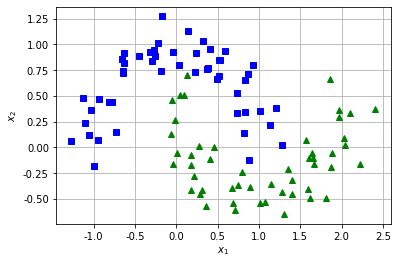

In [24]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset_moons(X, y):
    plt.plot(X[:,0][y==0], X[:,1][y==0], "bs")
    plt.plot(X[:,0][y==1], X[:,1][y==1], "g^")
    
    plt.grid(b=True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
plot_dataset_moons(X, y)
plt.show()

- `Scikit-Learn`的`PolynomialFeatures`实现进行特征的构造

In [25]:
from sklearn.preprocessing import PolynomialFeatures

In [26]:
polynomial_svm = Pipeline([
    ('PolynomialFeatures', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge'))
])

In [27]:
polynomial_svm.fit(X, y)

/Users/jin/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('PolynomialFeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [28]:
# 绘制决策边界
def plot_prediction(model):
    x0s = np.linspace(-1.5, 2.5, 100)
    x1s = np.linspace(-1, 1.5, 100)
    x0, x1 = np.meshgrid(x0s, x1s)      # 生成网格点坐标矩阵
    
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = model.predict(X).reshape(x0.shape)
    y_decision = model.decision_function(X).reshape(x0.shape)
    
    # 绘制等高线图
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)      # 分类超平面
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)   

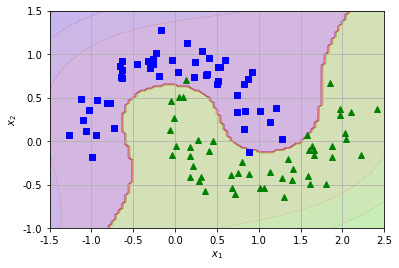

In [29]:
plot_prediction(polynomial_svm)
plot_dataset_moons(X, y)
plt.show()

## 多项式内核 Polynomial Kernel

添加多项式特征的缺点是如果多项式太低阶，处理不了非常复杂的数据集。而高阶则会创造出大量的特征，导致模型变得太慢。可以通过`核技巧`：直接在原来的低维空间中进行计算,而不需要显式地写出映射后的结果。

- linear: $\left\langle x, x^{\prime}\right\rangle$.
- polynomial: $\left(\gamma\left\langle x, x^{\prime}\right\rangle+r\right)^{d} \cdot d$ is specified by keyword `degree`, $r$ by `coefo`. 

`coefo`控制的是模型受高阶多项式还是低阶多项式的影响程度。

- 利用`Scikit-Learn`的`SVC()`的`kernel`参数，指定核函数

In [30]:
from sklearn.svm import SVC

In [31]:
# 3阶多项式内核训练SVM分类器
poly_3_kernel_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel="poly", C=5, degree=3, coef0=1))
])

poly_3_kernel_svm.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, cache_size=200, class_weight=None, coef0=1,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

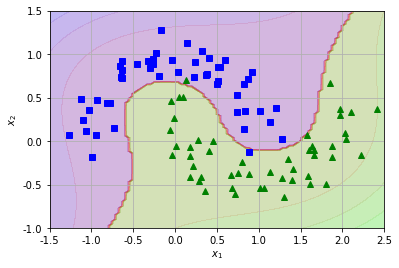

In [32]:
plot_prediction(poly_3_kernel_svm)
plot_dataset_moons(X, y)
plt.show()

In [33]:
# 10阶多项式内核训练SVM分类器
poly_10_kernel_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel="poly", C=5, degree=10, coef0=100))
])

poly_10_kernel_svm.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, cache_size=200, class_weight=None, coef0=100,
                     decision_function_shape='ovr', degree=10,
                     gamma='auto_deprecated', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

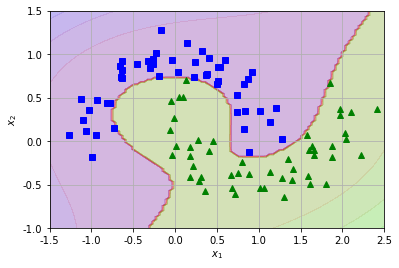

In [34]:
plot_prediction(poly_10_kernel_svm)
plot_dataset_moons(X, y)
plt.show()

寻找正确超参数的方法是`网格搜索`，先进行一次粗略的网格搜索，然后在最好的值附近展开一轮更加精细的网格搜索，这样通常会更快一些。多了解每个超参数实际实际上用来做什么的。有助于你在超参数空间正确搜索。

## 相似特征  Similarity Features

解决非线性的另一个技术是`添加相似特征`。这些相似特征是经过相似函数计算出的，相似函数可以测量每个实例与一个特定的地标之间的相似度。

>公式2: 高斯RBF Gaussian RBF
$$
\phi_{\gamma}(x, \ell)=\exp \left(-\gamma\|x-\ell\|^{2}\right)
$$

- 高斯核和多项式核干的事情截然不同的，如果对于样本数量少，特征多的数据集，高斯核相当于对样本降维。
- 高斯核的任务即找到更有利分类任务的新的空间。
- 高斯核运行开销耗时较大，训练时间较长。因此一般使用场景为数据集 (m, n)，m < n；

<img src="./images/other/5-5.png" width="600">

以$x_1=-2$,$x_1=1$处添加地标，采用RBF作为相似函数，\$\gamma=0.3$

例如：实例$x_1=-1$，它与第一个地标的距离为1，与第二个地表的距离为2.因此新特征为$x_2=e^{(-(0.3)×1^2)}≈0.74$,$x_3=e^{(-(0.3)×2^2)}≈0.30$。右图显示了转换后的数据集，由此可见数据呈线性可分离。

选择地标的一种方法是在数据集合里每一个实例的位置上创建一个地标，因此会增加了转换后的训练集线性可分离的机会。缺点是如果训练集非常大，那就会得到大数量的特征。

## 高斯RBF内核 Gaussian RBF Kernel

`rbf`: $\exp \left(-\gamma\left\|x-x^{\prime}\right\|^{2}\right) . \gamma$ is specified by keyword `gamma`, must be greater than 0 .

In [35]:
rbf_kernel_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', C=0.001, gamma=5))
])
rbf_kernel_svm.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

- 比较不同的`gamma`和`C`取值时的模型

In [36]:
gamma_1, gamma_2 = 0.1, 5
C_1, C_2 = 0.001, 1000
params = (gamma_1, C_1), (gamma_1, C_2), (gamma_2, C_1), (gamma_2, C_2)

In [37]:
models = []
for gamma, C in params:
    rbf_kernel_svm = Pipeline([
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(C=C, kernel='rbf', gamma=gamma))
    ])
    rbf_kernel_svm.fit(X, y)
    models.append(rbf_kernel_svm)

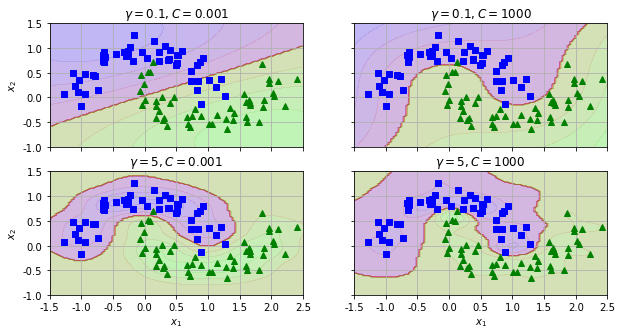

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), sharex=True, sharey=True)

# enumerate() 函数用于将一个可遍历的数据对象组合为一个索引序列，同时列出数据和数据下标
for i, model in enumerate(models):
    plt.sca(axes[i // 2, i % 2])   # sca()函数 选择子图  (0,0) (0,1) (1,0) (1,1)
    plot_prediction(model)
    plot_dataset_moons(X, y)
    
    gamma, C = params[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C))
    
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")


plt.show()

- 增加gamma的只会使钟型曲线变得更窄，因此每个实例的影响范围随之变小，决策边界变得更不规则，开始围绕着单体实例绕弯
- 反过来减少gamma的值，使钟型曲线变得更宽，因而每个实例影响范围增大，决策边界变得平坦，所以$\gamma$值就像一个正则化的参数C。

选择核函数的法则：
1. 首先从`线性核函数`开始尝试，特别是训练集特别大或特征特别多的时候。其中`LinearSVC`比`SVC(kernel="Linear")`要快得多。
2. 如果训练集不太大，可以尝试用`高斯RBS核`
3. 如果有多的时间和计算能力，可以使用交叉验证和网格搜索来尝试其他的核函数

## 计算复杂度 Computational Complexity

- `LinearSVC`基于的`liblinear库`为线性SVM实现了一个优化算法，该算法不支持核技巧，但是它与训练实例数量和特征数量几乎呈线性相关：其训练时间的复杂度大致为$O(m*n)$.如果你想要更高的精度，算法需要的时间更长.它的容差超参数ϵ来控制(`tol`),大多数分类任务中默认容差就够了。

- `SVC`基于的`libsvm库`,这个库的算法支持核技巧，训练时间的复杂度通常在$O(m^2*n)$和$O(m^3*n)$之间。因此这个算法完美适用于复杂但是中小型的数据集。但是它还是可以良好地适应特征数量的增加，特别是应对稀疏特征。这种情况下，算法复杂度大致与实例的平均非零特征数成比例。

`sklearn.svm`包中的`SVC(kernel=”linear“)`和`LinearSVC`的区别:

1. `LinearSVC`使用的是`平方hinge loss`，`SVC`使用的是`绝对值hinge loss`.绝对值hinge loss是非凸的，因而你不能用GD去优化，而平方hinge loss可以

2. `LinearSVC`使用的是One-vs-All（也成One-vs-Rest）的优化方法，而`SVC`使用的是One-vs-One

4. 对于二分类问题一般只有其中一个合适，具体问题具体对待

5. `LinearSVC`基于`liblinear`，罚函数是对截矩进行惩罚；`SVC`基于`libsvm`，罚函数不是对截矩进行惩罚。
SVM解决问题时，问题是分为线性可分和线性不可分问题的，`liblinear`对线性可分问题做了优化，故在大量数据上收敛速度比libsvm快.

<img src="./images/other/5-6.png" width="600">

# SVM回归 SVM Regression

对样本$f(x)$,传统回归模型通常直接基于模型输出$f(x)$与真实输出$y$之间的差别来计算损失，当且仅当$f(x)$与$y$完全一样时，损失才为0。与此不同，支持向量回归（SVR）假设我们能容$f(x)$与$y$之间最多有ϵ`(epsilon)`的误差，仅当$f(x)$与$y$之间的差的绝对值大于ϵ时才计算损失。
<img src="./images/other/5-7.png" width="400">

<img src="./images/other/5-8.png" width="600">

在间隔内添加更多的实例，不会影响模型的预测，所以这个模型又被称为`ϵ不敏感`。

- 解决非线性回归任务

In [39]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()  # y=0.2+0.1x+0.5x^2+高斯噪音

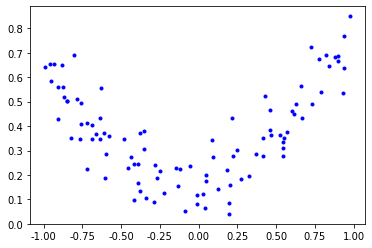

In [40]:
plt.plot(X, y, 'b.')
plt.show()

In [41]:
from sklearn.svm import SVR

In [42]:
# 比较不同的C取值时的模型

# C=100
svr_poly_reg_1 = SVR(C=100, kernel="poly", degree=2, epsilon=0.1 ,gamma="scale")
svr_poly_reg_1.fit(X, y)

# C=0.01
svr_poly_reg_2 = SVR(C=0.01, kernel="poly", degree=2, epsilon=0.1 ,gamma="scale")
svr_poly_reg_2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [43]:
def plot_SVR(model, X, y):
    x = np.linspace(-1, 1, 100).reshape(100, 1)
    y_pred = model.predict(x)
    
    plt.plot(x, y_pred, "k-", label=r"$\hat{y}$")
    plt.plot(x, y_pred + model.epsilon, "k--")
    plt.plot(x, y_pred - model.epsilon, "k--")
    
    plt.scatter(X[model.support_], y[model.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$",)
    plt.ylabel(r"$y$",)
    plt.legend(loc="upper left")
    plt.axis([-1, 1, 0, 1])

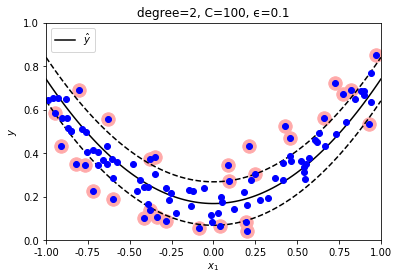

In [44]:
plot_SVR(svr_poly_reg_1, X, y)
plt.title("degree=2, C=100, ϵ=0.1")
plt.show()

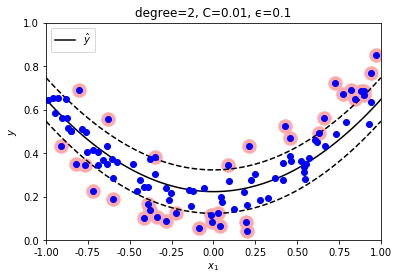

In [45]:
plot_SVR(svr_poly_reg_2, X, y)
plt.title("degree=2, C=0.01, ϵ=0.1")
plt.show()

可见上图几乎没有正则化(C很大)，二下图过度正则化(C很小)

参数C代表的是在线性不可分的情况下，对分类错误的惩罚程度。

- C值越大，表示整个优化过程中对于总误差$\sum_{i=1}^{n} \xi_{i}$的关注程度越高，对于减小误差的要求越高，甚至不惜使间隔减小，于是就造成过拟合。当C趋于无穷大时，这个问题也就是不允许出现分类误差的样本存在，那这就是一个硬间隔。
- C值过小时，分类器就会过于“不在乎”分类错误，于是分类性能就会较差。当C趋于0时，我们不再关注分类是否正确，只要求间隔越大越好，那么我们将无法得到有意义的解且算法不会收敛。


# 工作原理 Under the Hood

这里我们约定：偏置项表示为$b$,特征权重向量表示为$w$,同时输入特征向量时不添加偏置特征。

## 决策函数与预测

The linear SVM classifier model predicts the class of a new instance x by simply computing the decision function $w^T x + b = w_1 x_1 + ⋯ + w_n x_n + b$: if the result is positive, the predicted class $ŷ$ is the positive class (1), or else it is the negative class (0);

>公式3: 线性SVM分类器预测 Linear SVM classifier prediction
$$
\hat{y}=\left\{\begin{array}{l}
0 \text { if } \mathbf{w}^{T} \mathbf{x}+b<0 \\
1 \text { if } \mathbf{w}^{T} \mathbf{x}+b \geq 0
\end{array}\right.
$$

<img src="./images/other/5-9.png" width="400">

训练线性SVM分类器，意味着找到$W$和$b$的值，从而使这个虚线之间的间隔尽可能宽的同时，避免硬间隔或限制软间隔违例。

Training a linear SVM classifier means finding the value of $W$ and $b$ that make this margin as wide as possible while avoiding margin violations (hard margin) or limiting them (soft margin).

## 训练目标 Training Objective

<img src="./images/other/5-10.png" width="600">

决策函数的斜率等于权重向量的范数$\|w\|$,权重向量$w$越小，间隔越大，因此我们要最最小化$\|w\|$，来尽可能大的间隔。

- $\forall x_{0} \in \mathbf{R}^{n}$ 到 $\mathbf{S}$ 的距离:
$$
\frac{1}{\|w\|}\left|w \cdot x_{0}+b\right|
$$
若 $x_{0}$ 是正确分类点, 则
$$
\frac{1}{\|w\|}\left|w \cdot x_{0}+b\right|=\left\{\begin{aligned}
\frac{w \cdot x_{0}+b}{\|w\|}, & y_{0}=+1 \\
-\frac{w \cdot x_{0}+b}{\|w\|}, & y_{0}=-1
\end{aligned}\right.
$$
若 $x_{0}$ 是错误分类点, 则
$$
\frac{1}{\|w\|}\left|w \cdot x_{0}+b\right|=\left\{\begin{array}{l}
-\frac{w \cdot x_{0}+b}{\|w\|}, \quad y_{0}=+1 \\
\frac{w \cdot x_{0}+b}{\|w\|}, \quad y_{0}=-1
\end{array}=\frac{-y_{0}\left(w \cdot x_{0}+b\right)}{\|w\|}\right.
$$

>公式4: 硬间隔线性SVM分类器的目标 Hard margin linear SVM classifier objective
$$
\begin{array}{ll}
\underset{\mathbf{w}, b}{\operatorname{minimize}} & \frac{1}{2} \|w\| \\
\text { subject to } & t^{(i)}\left(\mathbf{w}^{T} \mathbf{x}^{(i)}+b\right) \geq 1 \quad \text { for } i=1,2, \cdots, m
\end{array}
$$

为了达到软间隔的目的，引入一个松弛变量。因此，产生了两个相互冲突的目标：
1. 使松弛变量越小越好，从而减少为间隔违例
2. $\frac{1}{2} \|w\|$最小化以增大间隔

>公式5: 软间隔线性SVM分类器的目标 Soft margin linear SVM classifier objective
$$
\begin{array}{l}
\underset{\mathbf{w}, b, \zeta}{\operatorname{minimize}} \quad \frac{1}{2} \|w\|+C \sum_{i=1}^{m} \zeta^{(i)}\\
\text { subject to } t^{(i)}\left(\mathbf{w}^{T} \mathbf{x}^{(i)}+b\right) \geq 1-\zeta^{(i)} \text { and } \zeta^{(i)} \geq 0 \text { for } i=1,2, \cdots, m
\end{array}
$$

## 对偶问题 The Dual Problem

>公式6: 线性SVM目标的对偶形式 Dual form of the linear SVM objective
$$
\min _{\alpha} \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j}\left(x_{i} \cdot x_{j}\right)-\sum_{i=1}^{N} \alpha_{i}\\
\text { s.t. }  \sum_{i=1}^{N} \alpha_{i} y_{i}=0 , 0≤a_i≥C，i=1,2,...,m\\
$$

>公式7: 从对偶问题到原始问题 From the dual solution to the primal solution
$$
w^{*}=\sum_{i=1}^{N} \alpha_{i}^{*} y_{i} x_{i}  \\
b^{*}=y_{j}-\sum_{i=1}^{N} y_{i} \alpha_{i}^{*}\left(x_{i} \cdot x_{j}\right)
$$

## 内核化SVM Kernelized SVM

>公式8: 常用核函数 Common kernels
<img src="./images/other/5-11.png" width="600">

## 在线SVM Online SVMs

>公式9: 线性SVM分类器成本函数 Linear SVM classifier cost function
$$
J(\mathbf{w}, b)=\frac{1}{2} \mathbf{w}^{T} \mathbf{w} + C \sum_{i=1}^{m} \max \left(0,1-t^{(i)}\left(\mathbf{w}^{T} \mathbf{x}^{(i)}+b\right)\right)
$$

对于线性SVM分类器一种实现在线SVM分类器的方法是使用梯度下降来最小化成本函数。但梯度下降比基于QP的方法收敛慢得多。

<img src="./images/other/5-12.png" width="400">

# 练习题 Exercise

##  ex. 1

Q: 支持向量机的基本思想是什么?

>The fundamental idea behind **Support Vector Machines** is to fit the widest possible “street” between the classes. In other words, **the goal is to have the largest possible margin between the decision boundary** that separates the two classes and the training instances. When performing **soft margin classification**, the SVM searches for a compromise between perfectly separating the two classes and having the widest possible street (i.e., **a few instances may end up on the street**). Another key idea is to **use kernels when training on nonlinear datasets**.

## ex.2

Q: 什么是支持向量？

> After training an SVM, a support vector is any instance located on the “street” (see the previous answer), including its border.**The decision boundary is entirely determined by the support vectors.** Any instance that is not a support vector (i.e., is off the street) has no influence whatsoever; you could remove them, add more instances, or move them around, and as long as they stay off the street they won’t affect the decision boundary. **Computing the predictions only involves the support vectors**, not the whole training set.

## ex.3

Q: 使用 SVM 时,对输入值进行缩放为什么重要?

> SVMs try to fit the largest possible “street” between the classes (see the first answer), so **if the training set is not scaled, the SVM will tend to neglect small features** (see 1.2).

## ex.4

Q: SVM 分类器在对实例进行分类时,会输出信心分数吗?概率呢?

> **An SVM classifier can output the distance between the test instance and the decision boundary, and you can use this as a confidence score.** However, this score cannot be directly converted into an estimation of the class probability. If you set `probability=True` when creating an SVM in Scikit-Learn, then after training it will calibrate the probabilities using Logistic Regression on the SVM’s scores (trained by an additional five-fold cross-validation on the training data). This will add the `predict_proba()` and `predict_log_proba()` methods to the SVM.

## ex.5

Q: 如果训练集有成百万个实例和几百个特征,你应该使用 SVM 原始问题还是对偶问题来训练模型? 

> This question applies only to **linear SVMs** since **kernelized SVMs can only use the dual form**. The computational complexity of the primal form of the SVM problem is proportional to the number of training instances $m$, while the computational complexity of the dual form is proportional to a number between $m^2$ and $m^3$ . So **if there are millions of instances, you should definitely use the primal form**, because the dual form will be much too slow.

## ex.6

Q: 假设你用 `RBF 核`训练了一个 SVM 分类器,看起来似乎对训练集欠拟合,你应该提升还是降低 $\gamma$(gamma) ? C呢?

>If an SVM classifier trained with an RBF kernel underfits the training set, there might be too much regularization. **To decrease it, you need to increase gamma or C (or both).**

## ex.7

Q: 如果使用现成二次规划求解器,你应该如何设置 QP 参数($H、f、A和 b$)来解决软间隔线性 SVM 分类器问题?

## ex.8

Q: 在一个线性可分离数据集上训练 `LinearSVC`。然后在同一数据集上训练 `SVC` 和`SGDClassifier`,看看你是否可以用它们产生大致相同的模型。

In [46]:
from sklearn.linear_model import SGDClassifier

In [47]:
# 加载数据
iris = datasets.load_iris()
X = iris['data'][:,(2,3)]  # 花瓣的长度和宽度
y = iris['target']

# 仅对变色鸢尾和山鸢尾进行分类
target = (y==0) | (y==1)   
X = X[target]
y = y[target]

In [48]:
# 特征缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
# 模型拟合
LinearSVC_model = LinearSVC(C=5, loss="hinge", random_state=42)
SVC_model = SVC(C=5, kernel="linear")
SGD_model = SGDClassifier(max_iter=1000,      # 最大迭代次数
                          tol=1e-3,           # 迭代终止误差限
                          learning_rate="constant", # 使用eta0来指定学习率
                          eta0=0.001,         # 初始学习率
                          random_state=42,
                          alpha=0.002,        # 正则化强度
                          loss='hinge'
                         )

LinearSVC_model.fit(X_scaled, y)
SVC_model.fit(X_scaled, y)
SGD_model.fit(X_scaled, y)

SGDClassifier(alpha=0.002, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [50]:
# 特征权重 截距项
print("LinearSVC:",LinearSVC_model.coef_,LinearSVC_model.intercept_)
print("SVC:",SVC_model.coef_,SVC_model.intercept_)
print("SGD:",SGD_model.coef_,SGD_model.intercept_)

LinearSVC: [[1.05364923 1.09903601]] [0.28474532]
SVC: [[1.1203284  1.02625193]] [0.31896852]
SGD: [[0.77714169 0.72981762]] [0.117]


In [51]:
# 绘制决策边界 转化为未经过特征缩放的参数
def convert_param(model, scaler=scaler):
    w = -model.coef_[0,0] / model.coef_[0,1]
    b = -model.intercept_[0] / model.coef_[0,1]
    
    # inverse_transform() 将标准化后的数据转换为原始数据。
    line = scaler.inverse_transform([
        [-10, -10*w+b], [10, 10*w+b]
    ])    
    
    return line

LinearSVC_line = convert_param(LinearSVC_model)
SVC_line = convert_param(SVC_model)
SGD_line = convert_param(SGD_model)

In [52]:
LinearSVC_line

array([[-11.56182566,   6.03129158],
       [ 17.28382566,  -4.75067065]])

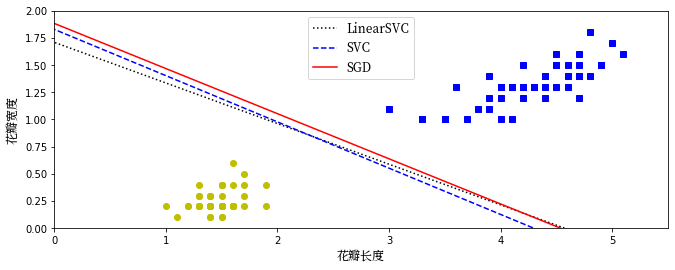

In [53]:
plt.figure(figsize=(11,4))
plt.plot(LinearSVC_line[:,0], LinearSVC_line[:,1], "k:", label="LinearSVC")
plt.plot(SVC_line[:,0], SVC_line[:,1], "b--", label="SVC")
plt.plot(SGD_line[:,0], SGD_line[:,1], "r-", label="SGD")

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # 变色鸢尾
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # 山鸢尾

plt.xlabel("花瓣长度", fontproperties=my_font)
plt.ylabel("花瓣宽度", fontproperties=my_font)
plt.legend(loc="upper center", prop=my_font)

plt.axis([0, 5.5, 0, 2])
plt.show()

## ex.9

Q: 在 MNIST 数据集上训练 SVM 分类器。由于 SVM 分类器是个二元分类器,所以你需要使用一对多来为10个数字进行分类。你可能还需要使用小型验证集来调整超参数以加快进度。最后看看达到的准确率是多少?

- 首先，让我们加载数据集并将其分割为训练集和测试集。 可以使用`train_test_split()`，但人们通常只是前60,000个实例作为训练集，以及最后10,000个实例作为测试集.

In [54]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, cache=True, )

X = mnist["data"].astype(np.float32)
y = mnist["target"].astype(np.uint8)  # 将标签类型由str转成整型

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [55]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

- 由于数据集已经实现了混洗，所以免去这一步骤。接下来训练SVM分类器，使用一对多(OVR)策略。

In [56]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

/Users/jin/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

- 对训练集上的数据进行预测，评估精准度

In [57]:
from sklearn.metrics import accuracy_score

In [58]:
y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.895

- 精准度89.5%比较糟糕，考虑去缩放数据

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

/Users/jin/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [61]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9225333333333333

- 精准度得到了提升，但是仍然不够好，尝试使用核函数：`SVC(kernel="rbf")`

In [62]:
svc_model = SVC(gamma="scale", kernel="rbf")
svc_model.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [63]:
y_pred = svc_model.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9455333333333333

- 结果是可喜的，因为仅有六分之一训练集数据的情况下得到了比之前更好的性能。接下来通过`交叉验证集`进行`随机搜索`调整超参数，这里仅在一个小型验证集进行此操作以加快进度。

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [65]:
param_distribs = {
    "gamma":reciprocal(0.001, 0.1),  # 逆高斯分布
    "C":uniform(1, 10)               # 均匀连续随机变量
}
rnd_search = RandomizedSearchCV(estimator=svc_model, 
                                param_distributions=param_distribs,
                                n_iter=10,   # 指定训练次数
                                cv=3, 
                                random_state=42,
                                verbose=2,  # verbose：日志冗长度
                                n_jobs=-1
                               )
rnd_search.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    4.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='scale', kernel='rbf',
                                 max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbc60884f90>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbc60884510>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

- 获取最佳的参数组合

In [66]:
rnd_search.best_params_

{'C': 2.560186404424365, 'gamma': 0.002051110418843397}

- 最佳评估分数

In [67]:
rnd_search.best_score_

0.851

- 由于这仅仅是在1000个实例所训练得到的分数，让我们在整个训练集上重新训练最佳估算器

In [68]:
# 运行时间长
rnd_search.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=2.560186404424365, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.002051110418843397,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [69]:
y_pred = rnd_search.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9973666666666666

- 运用此模型在测试集上进行测试

In [71]:
y_pred = rnd_search.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9708

并不是很糟糕，但显然模型略微过拟合。 调整超参数似乎能起到效果（例如，减少`C`和或`gamma`），但我们会增加测试集过拟合的风险。研究发现，将超参数设置为`C = 5`和`gamma= 0.005`产生更好的性能（超过98％的精度）。 通过运行随机搜索和更大的数据集，你也可以找到它这样的参数。

## ex.10

Q: 在加州住房数据集上训练一个 SVM 回归模型。

In [72]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing['data']
y = housing['target']

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

/Users/jin/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [76]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_true=y_train, y_pred=y_pred)
mse

0.954517044073374

In [77]:
rmse = np.sqrt(mse)
rmse

0.976993881287582

- 尝试使用核函数：`SVC(kernel="rbf")`以及不同的超参数

In [79]:
from sklearn.svm import SVR

param_distribs = {
    "gamma":reciprocal(0.001, 0.1),
    "C":uniform(1, 10)   # 均匀连续随机变量
}
rnd_search = RandomizedSearchCV(estimator=SVR(), 
                                param_distributions=param_distribs,
                                n_iter=10,   # 指定训练次数
                                cv=3, 
                                random_state=42,
                                verbose=2,  # verbose：日志冗长度
                                #n_jobs=-1
                               )
rnd_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.3s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.6s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.2s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.3s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   4.7s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.0s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   4.8s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   5.2s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbc60f0e1d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbc60f0e8d0>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [80]:
rnd_search.best_estimator_

SVR(C=4.745401188473625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [81]:
y_pred = rnd_search.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785359

看起来比线性模型好得多。选择此模型并在测试集上进行评估:

In [82]:
y_pred = rnd_search.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.5929168385528734

> Apotosome 08/10/21